# Deep Learning II
Actividad Lección 14 || Programación Python para Machine Learning

Objetivos:
* Conocer los principios en los que se basan y la utilidad de las Redes Convolucionales.
* Dominar las técnicas para la implementación en Python de Redes Convolucionales.

Datos del alumno:
* Víctor Luque Martín
* Máster Avanzado en Programación en Python para Hacking, BigData y Machine Learning

Fecha: 29/01/2023

# Tabla de Contenidos
1. [Importes](#importes)
2. [Carga de datos](#carga-de-datos)
3. [Preprocesado de datos](#preprocesado-de-datos)
4. [Red Neuronal Convolucional](#cnn)
5. [Matriz de Confusión](#cm)
6. [Conclusión](#conclusion)

# Importes <a class="anchor" id="importes"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random, time
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from keras import layers
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

# Carga de datos <a class="anchor" id="carga-de-datos"></a>
Se cargarán los datos del dataset Rock Paper Scissors incluidos en la librería de Tensorflow-Datasets. Previamente se debe instalar la librería con el comando `pip install tensorflow-datasets`.

In [2]:
(x_train, y_train), (x_test, y_test) = tfds.as_numpy(tfds.load('rock_paper_scissors', split=['train', 'test'], batch_size=-1, as_supervised=True))

# Preprocesado de datos <a class="anchor" id="preprocesado-de-datos"></a>
Los datos vienen dispuestos en un formato de imágenes de 300x300 pixeles en formato RGB. Se procede a normalizar los datos y a dividirlos en un conjunto de entrenamiento y otro de test. Para ello realizamos las siguientes operaciones:
1. Obtención del número de clases.
2. Obtención del tamaño de las imágenes.
3. Normalización de los datos (conversión a float32 y división entre 255).
4. Catetgorización de las etiquetas.

In [3]:
# Obtención del número de clases (Valores únicos en y_train)
num_classes = len(np.unique(y_train))
num_classes

3

In [4]:
# Tamaño de las imágenes
input_size = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
input_size

(300, 300, 3)

In [5]:
# Normalización
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

In [6]:
# Categorización
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Red Neuronal Convolucional <a class="anchor" id="cnn"></a>
Una red neuronal convolucional (Convolutional Neural Network, CNN) es un tipo de red neuronal artificial utilizada en tareas de `Deep Learning`, especialmente en el análisis de imágenes y reconocimiento de patrones. Las características clave de una CNN son la utilización de capas de convolución para extraer características relevantes de los datos de entrada y la utilización de pooling para reducir la dimensionalidad de los datos.

A continuación se muestra el modelo de la CNN que se va a implementar:

In [7]:
seed = random.seed(time.time())

model = keras.Sequential([
    keras.Input(shape=input_size),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(512, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(.5),
    layers.Dense(num_classes, activation='softmax')
])

optimizer = Adam(learning_rate=0.0001)
loss = CategoricalCrossentropy()

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 512)       590336    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 512)      0

Una vez definida la red, se debe realizar un entrenamiento de la misma, donde se irá perfeccionando el modelo mediante un número de épocas.

In [8]:
history = model.fit(x_train, y_train, epochs=10, validation_split=0.2)
model_history = pd.DataFrame(history.history)
model_history['epoch'] = history.epoch
model_history

Epoch 1/10
63/63 [==============================] - 23s 296ms/step - loss: 0.9921 - accuracy: 0.6042 - val_loss: 0.3048 - val_accuracy: 0.9643
Epoch 2/10
63/63 [==============================] - 17s 276ms/step - loss: 0.2286 - accuracy: 0.9400 - val_loss: 0.0522 - val_accuracy: 0.9940
Epoch 3/10
63/63 [==============================] - 17s 278ms/step - loss: 0.1003 - accuracy: 0.9697 - val_loss: 0.0155 - val_accuracy: 1.0000
Epoch 4/10
63/63 [==============================] - 18s 281ms/step - loss: 0.0603 - accuracy: 0.9851 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 5/10
63/63 [==============================] - 18s 284ms/step - loss: 0.0373 - accuracy: 0.9901 - val_loss: 9.2928e-04 - val_accuracy: 1.0000
Epoch 6/10
63/63 [==============================] - 18s 282ms/step - loss: 0.0256 - accuracy: 0.9940 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 7/10
63/63 [==============================] - 18s 281ms/step - loss: 0.0249 - accuracy: 0.9916 - val_loss: 0.0011 - val_accuracy: 1.

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.992056,0.604167,0.304833,0.964286,0
1,0.228550,0.939980,0.052183,0.994048,1
2,0.100300,0.969742,0.015489,1.000000,2
3,0.060260,0.985119,0.005548,1.000000,3
4,0.037308,0.990079,0.000929,1.000000,4
5,0.025639,0.994048,0.001080,1.000000,5
6,0.024911,0.991567,0.001055,1.000000,6
7,0.021357,0.995040,0.000183,1.000000,7
8,0.016714,0.994048,0.000213,1.000000,8
9,0.013656,0.995040,0.000032,1.000000,9


Tras realizar la fase de entrenamiento, es posible visualizar la evolución del rendimiento de la red neuronal profunda.

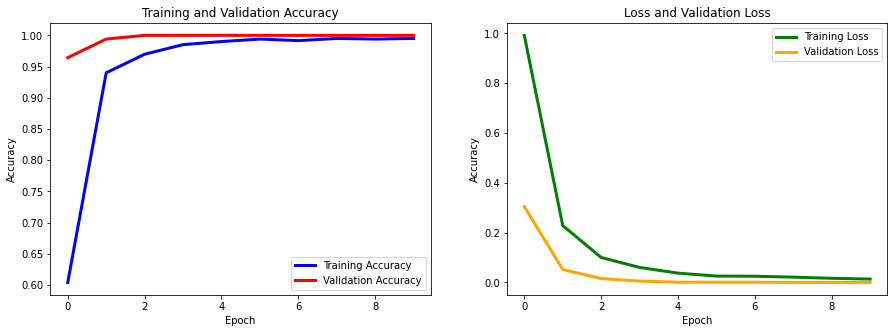

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
num_epochs = model_history.shape[0]
ax[0].plot(np.arange(0, num_epochs), model_history['accuracy'], label='Training Accuracy', lw=3, color='blue')
ax[0].plot(np.arange(0, num_epochs), model_history['val_accuracy'], label='Validation Accuracy', lw=3, color='red')
ax[1].plot(np.arange(0, num_epochs), model_history['loss'], label='Training Loss', lw=3, color='green')
ax[1].plot(np.arange(0, num_epochs), model_history['val_loss'], label='Validation Loss', lw=3, color='orange')
ax[0].set_title('Training and Validation Accuracy')
ax[1].set_title('Loss and Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()

A continuación, evaluaremos los datos de set con el modelo generado y visualizaremos los valores de precisión y pérdida obtenidas.

In [10]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Loss: 0.7088
Accuracy: 0.8360


# Matriz de Confusión <a class="anchor" id="cm"></a>
Comprobaremos el rendimiento del modelo mediante la matriz de confusión.

12/12 [==============================] - 1s 96ms/step


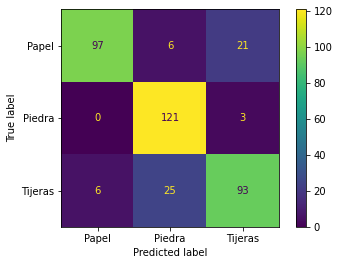

In [11]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Papel', 'Piedra', 'Tijeras'])
disp.plot()
plt.show()

# Conclusion <a class="anchor" id="conclusion"></a>
Como podemos observar, la CNN ha obtenido un rendimiento de aproximadamente el 80% de precisión, lo que es un buen resultado para un modelo de este tipo.